In [1]:
import numpy as np
import qiskit as qk
from qiskit.circuit import QuantumCircuit, Parameter
import qutip as qt
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display

In [2]:
# Set up parameters of the Heisenberg Model
J=1.
Bx=1.
By=1.
Bz=1.
N=4
delta_t=0.05
tlist=np.arange(50)*0.05

# Classical Simulation of the Heisenberg model

In the following we provide some code that utilizes `qutip` to solve this Schroedinger equation for the Trotterized simulation

In [3]:
def classically_simulate_Heisenberg_chain(N, J, Bx, By, Bz, psi0, tlist):
    '''
    This function takes in the following parameters
    N = Number of spins (Integer)
    J = Strength of Coupling (Floating point number)
    Bx, By, Bz = Strength of Magnetic field (Floating point number)
    psi0 = Initial state of the spin system
    tlist = List of times at which the wavefunction is calculated

    returns the expectation value of <sx(t)>,<sy(t)>,<sz(t)>
    '''
    si = qt.qeye(2)
    sx = qt.sigmax()
    sy = qt.sigmay()
    sz = qt.sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H +=  0.5 * Bx * sx_list[n]
        H +=  0.5 * By * sy_list[n]
        H +=  0.5 * Bz * sz_list[n]

    # interaction terms
    for n in range(N-1):
        H +=  0.5 * J * sx_list[n] * sx_list[n+1]
        H +=  0.5 * J * sy_list[n] * sy_list[n+1]
        H +=  0.5 * J * sz_list[n] * sz_list[n+1]


    # evolve and calculate expectation value of sx, sy and sz
    result = qt.mesolve(H, psi0, tlist, e_ops=sx_list+sy_list+sz_list)
    sx_expectval=(1/N)*np.sum(np.real(result.expect)[0:len(sx_list),:],0)
    sy_expectval=(1/N)*np.sum(np.real(result.expect)[len(sx_list):len(sx_list)+len(sy_list),:],0) 
    sz_expectval=(1/N)*np.sum(np.real(result.expect)[len(sx_list)+len(sy_list):len(sx_list)+len(sy_list)+len(sz_list),:],0)
    return sx_expectval,sy_expectval, sz_expectval

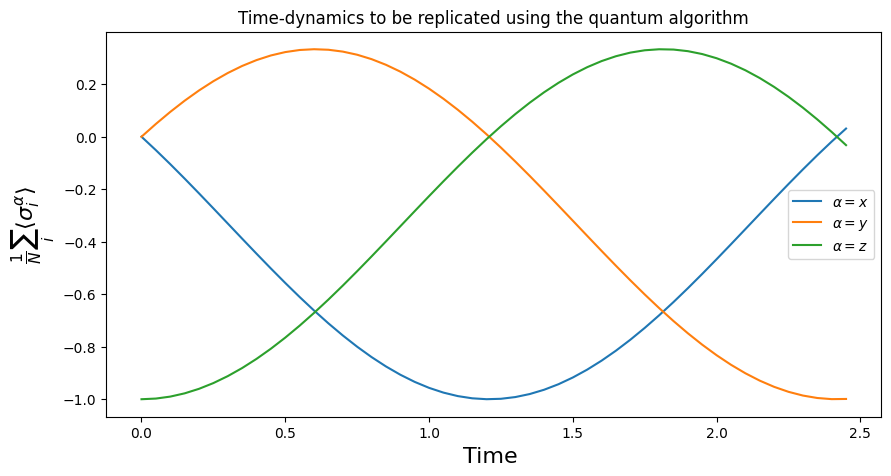

In [4]:
# intial state, all spins in state |1111>
psi0 = qt.tensor([qt.basis(2,1),qt.basis(2,1),qt.basis(2,1),qt.basis(2,1)]) # Tensor product the list to generate the initial state
sx_expt,sy_expt,sz_expt = classically_simulate_Heisenberg_chain(N, J, Bx, By, Bz, psi0, tlist)
plt.subplots(figsize=(10,5))
plt.plot(tlist, sx_expt,c='C0',label=r'$\alpha=x$')
plt.xlabel(r'Time ',fontsize=16)
plt.ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^\alpha_i \rangle$',fontsize=16)
plt.plot(tlist, sy_expt,c='C1',label=r'$\alpha=y$')
plt.plot(tlist, sz_expt,c='C2',label=r'$\alpha=z$')
plt.title('Time-dynamics to be replicated using the quantum algorithm')
plt.legend()

# Quantum Simulation of Heisenberg Chain

To simulate the dynamics using the Hamiltonian Simulation we need to do the following steps
1. Prepare the Initial State
2. Realize the decomposition of the $N$ qubit unitary in terms of one and two qubit gates
3. Reconstruct the desired observable from the measurments.

In [5]:
#Quantum computer parameters
backend = qk.Aer.get_backend('qasm_simulator')
num_shots=1000000 

## Prepare the initial state  [To Do]

Prepare an initial state that is the state $|1111\rangle$ and check that the circuit creates this state by performing measurements.

In [6]:
def create_initial_state(circ):
    '''
    Create and return a circuit for  the initial state for the experiment.
    Here we would like to prepare the |1>|1>|1>|1> state.
    '''
    '''
    Fill Here
    '''
    circ.x(circ.qubits)
    return circ

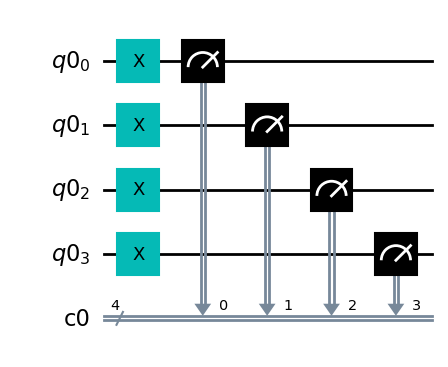

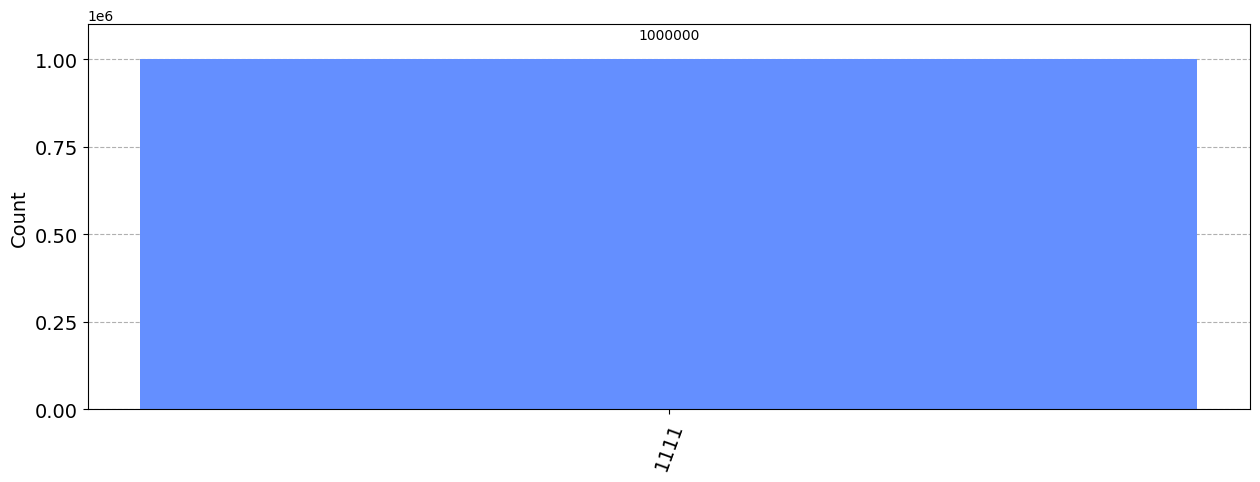

In [7]:
# Test that the initial state created by the function is the |1111> state.
# Create a circuit and measure the output to make sure that this state is  |1111>
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ = qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ)
circ.measure(qr,cr)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=num_shots)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5)) #check the probability

## Creating the Unitary for two qubit interactions [To Do]
Next we look at creating two-qubit interactions as desired from the Hamiltonian. The interactions in the Ising model mean that  we are interested in realizing the following general two-qubit gate,

\begin{align}
U_{\rm Ising}=e^{-i\frac{\theta}{2}( \sigma^x\otimes \sigma^x+\sigma^y\otimes \sigma^y+\sigma^z\otimes \sigma^z)}
\end{align}

For the parameters chosen in this notebook, it becomes convenient to choose the Rxx gate provided by qiskit. In general we will have to transpile an arbitrary two qubit unitary to the native gate set.

In [8]:
def Rxyz(theta):
    '''
    Implements the Heisenberg interaction unitary gate.
    Returns a two-qubit circuit with the standard Rxyz(theta) gate applied between 0 and 1.
    '''
    circ=qk.QuantumCircuit(2)
    '''
    Fill Here
    '''
    circ.rz(-np.pi/2, 1)
    circ.cx(1,  0)
    circ.rz(theta+np.pi/2, 0)
    circ.ry(-np.pi/2-theta, 1)
    circ.cx(0, 1)
    circ.ry(theta+np.pi/2, 1)
    circ.cx(1, 0)
    circ.rz(np.pi/2, 0)
    return circ

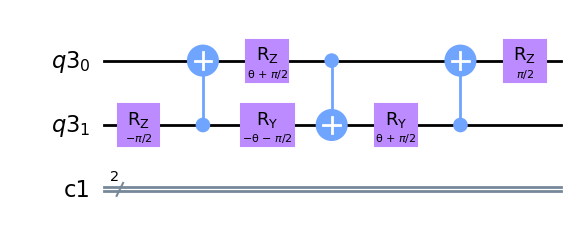

In [9]:
# test your Rxyz(theta) gate by printing out the circuit
theta=qk.circuit.Parameter('θ')
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ=circ.compose(Rxyz(theta),[qr1[0],qr1[1]])
display(circ.draw('mpl'))


## Creating the Unitary for a single time-step 

Now we are ready to create the Unitary operator for the Heisenberg Hamiltonian by composing one and two qubit gates. 

### Unitary using First Order Product Formula

In [22]:
def first_order_PF_step(circ,delta_t,J,Bx,By,Bz):
    '''
    Applies a Unitary for a single time step U(Δt) using first-order trotter expansion to the input quantum circuit.
    input : circ is a quantum circuit
    output : circ-U(Δt)-
    '''
    circ.barrier()
    '''
    Fill Here
    '''
    qr = circ.qubits
    circ.compose(Rxyz(delta_t*J),[qr[0],qr[1]], inplace=True)
    circ.compose(Rxyz(delta_t*J),[qr[2],qr[3]], inplace=True)
    circ.compose(Rxyz(delta_t*J),[qr[1],qr[2]], inplace=True)
    
    # separating H1 and H2
    circ.barrier()
        
    for qubit in qr:
        circ.rx(delta_t*Bx, qubit)
        circ.ry(delta_t*By, qubit)
        circ.rz(delta_t*Bz, qubit)
    
    return circ

def first_order_PF(circ,t,m,J,Bx,By,Bz):
    delta_t=t/m
    '''
    Fill Here
    '''
    for _ in range(m):
        first_order_PF_step(circ, delta_t, J, Bx, By, Bz)
    return circ
    

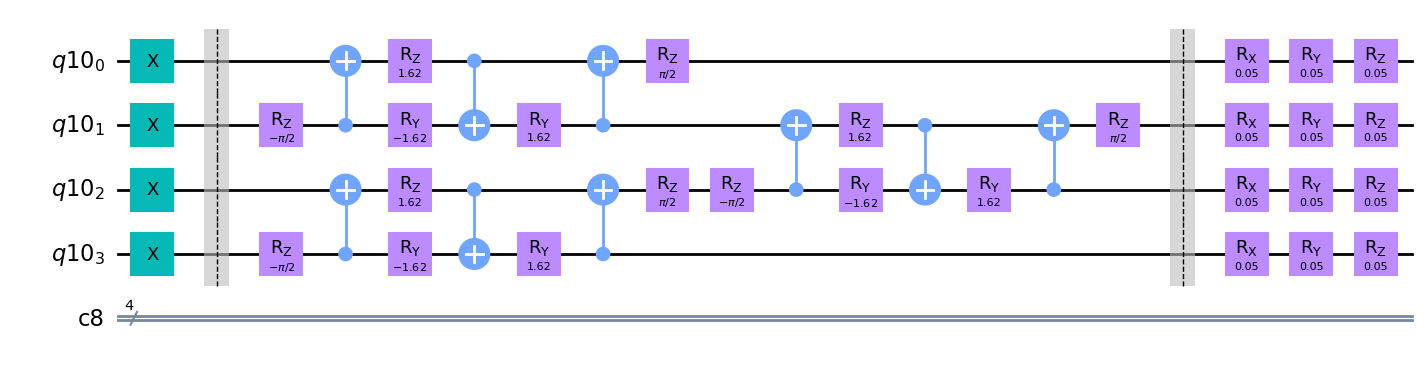

In [23]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ)
circ=first_order_PF_step(circ,delta_t,J,Bx,By,Bz)
circ.draw('mpl')

## Measuring $m_x$, $m_y$ and $m_z$

Finally we need to measure expectation values from probabilities of measuring in particular basis states. 

In [29]:
def measure_m(basis_states,p_list):
    '''
    Takes input of probabilities for states for measurement in alpha={x or y or z} basis,
    and returns expectation value of <sigma_alpha> in that basis
    '''
    m_expectval=0
    '''
    Fill Here
    '''
    # this was determined by considering that for 0000 all spins are up, so they contribute +4*s magnetic moment
    # for 1111 they contribute -4*s since they are all spin down
    # states with an even number of 1's and 0's contribute zero since there magnetic moment is zero
    # then states with 3 0's or 3 1's contribute \pm 1/2
    m_expectval += p_list[0]
    m_expectval += 0.5*(p_list[1]+p_list[2]+p_list[4]+p_list[8])
    m_expectval -= 0.5*(p_list[7]+p_list[11]+p_list[13]+p_list[14])
    m_expectval -= p_list[15]
    
    return m_expectval  

def measurement_circuits(circ):
    
    circ_x=circ.copy()
    circ_x.name=circ_x.name+'-x'
    qr_x = circ_x.qubits
    cr_x = circ_x.clbits
    '''
    Fill Here
    '''    
    circ_x.h(qr_x)
    circ_x.measure(qr_x, cr_x)
                               
    circ_y=circ.copy()
    circ_y.name=circ_y.name+'-y'
    qr_y = circ_y.qubits
    cr_y = circ_y.clbits
    '''
    Fill Here
    '''
    circ_y.sdg(qr_y)
    circ_y.h(qr_y)
    circ_y.measure(qr_y, cr_y)
                               
    circ_z=circ.copy()
    circ_z.name=circ_z.name+'-z'
    qr_z = circ_z.qubits
    cr_z = circ_z.clbits
    '''
    Fill Here
    '''
    circ_z.measure(qr_z,cr_z) 
    return [circ_x,circ_y,circ_z]
    

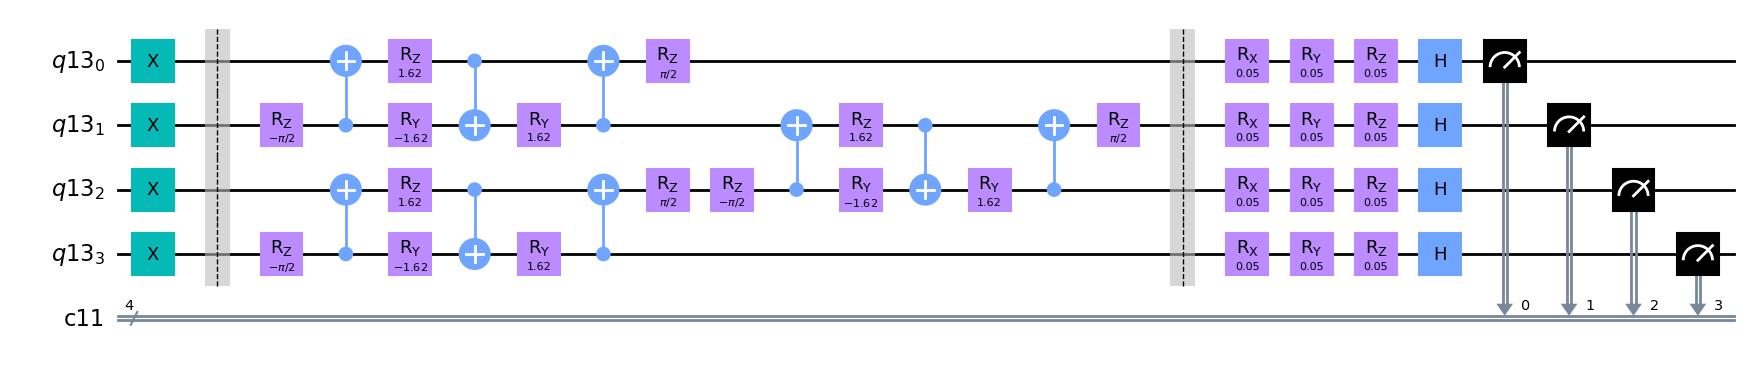

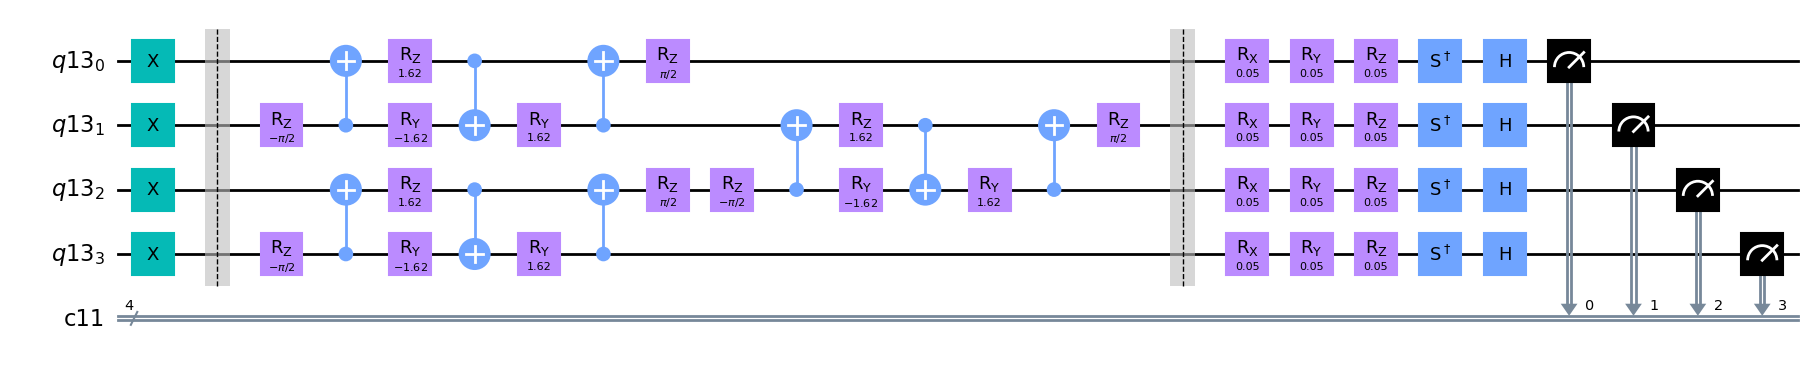

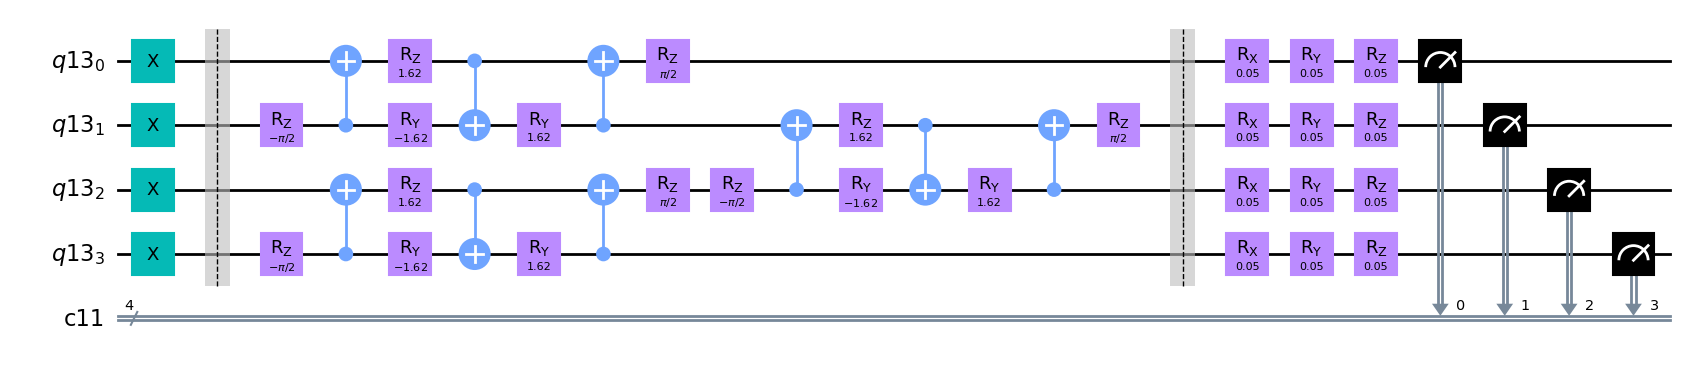

In [30]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ)
circ=first_order_PF_step(circ,delta_t,J,Bx,By,Bz)

circ_list=measurement_circuits(circ)
display(circ_list[0].draw('mpl',fold=-1))
display(circ_list[1].draw('mpl',fold=-1))
display(circ_list[2].draw('mpl',fold=-1))

## Bringing it all together to simulate the dynamics

Finally, let's bring together the state preparation, hamiltonian simulation and measurement to measure the required observable and compare with the classical simulation.

### First order Trotter Simulation

In [48]:
def countsToProbs(myDict, num_shots):
    probs = []
    for i in range(16):
        bitString = format(i, '04b')
        #print(bitString)
        try:
            probs.append( myDict[bitString] /num_shots )
        except KeyError:
            probs.append( 0.0 )
    return probs

num_shots = 100000 # 100000, set lower for testing
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ)
mx_list=[] # list of values containing mx
my_list=[] # list of values containing my
mz_list=[] # list of values containing mz
for p in range(len(tlist)-1):
    first_order_PF_step(circ, delta_t, J, Bx, By, Bz)
    
    circ_list=measurement_circuits(circ)
    
    job_x = qk.execute(circ_list[0], backend=backend,shots=num_shots) # x circuit
    result_x = job_x.result()
    #print(job_x.result().get_counts())
    px_list = countsToProbs(result_x.get_counts(), num_shots)
    
    job_y = qk.execute(circ_list[1], backend=backend,shots=num_shots) # y circuit
    result_y = job_y.result()
    #print(job_y.result().get_counts())
    py_list = countsToProbs(result_y.get_counts(), num_shots)
    
    
    job_z = qk.execute(circ_list[2], backend=backend,shots=num_shots) # z circuit
    result_z = job_z.result()
    #print(job_z.result().get_counts())
    pz_list = countsToProbs(result_z.get_counts(), num_shots)
    
    basis_states_x = basis_states_y = basis_states_z = None
    '''
    Fill Here
    '''
    mx_list.append(measure_m(basis_states_x,px_list))
    my_list.append(measure_m(basis_states_y,py_list))
    mz_list.append(measure_m(basis_states_z,pz_list))
    
    print("Finished %dth iteration" % p)

Finished 0th iteration
Finished 1th iteration
Finished 2th iteration
Finished 3th iteration
Finished 4th iteration
Finished 5th iteration
Finished 6th iteration
Finished 7th iteration
Finished 8th iteration
Finished 9th iteration
Finished 10th iteration
Finished 11th iteration
Finished 12th iteration
Finished 13th iteration
Finished 14th iteration
Finished 15th iteration
Finished 16th iteration
Finished 17th iteration
Finished 18th iteration
Finished 19th iteration
Finished 20th iteration
Finished 21th iteration
Finished 22th iteration
Finished 23th iteration
Finished 24th iteration
Finished 25th iteration
Finished 26th iteration
Finished 27th iteration
Finished 28th iteration
Finished 29th iteration
Finished 30th iteration
Finished 31th iteration
Finished 32th iteration
Finished 33th iteration
Finished 34th iteration
Finished 35th iteration
Finished 36th iteration
Finished 37th iteration
Finished 38th iteration
Finished 39th iteration
Finished 40th iteration
Finished 41th iteration
Fi

Text(0.5, 1.0, 'Time-dynamics of a Spin Chain through Hamiltonian Simulation')

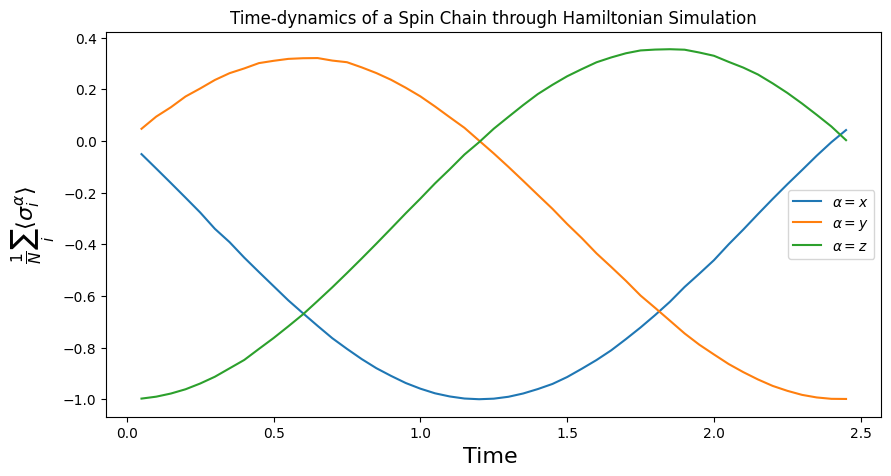

In [50]:
plt.subplots(figsize=(10,5))
plt.plot(tlist[1:], mx_list,c='C0',label=r'$\alpha=x$')
plt.xlabel(r'Time ',fontsize=16)
plt.ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^\alpha_i \rangle$',fontsize=16)
plt.plot(tlist[1:], my_list,c='C1',label=r'$\alpha=y$')
plt.plot(tlist[1:], mz_list,c='C2',label=r'$\alpha=z$')
plt.legend()      
plt.title("Time-dynamics of a Spin Chain through Hamiltonian Simulation")

# Comparison between quantum simulation and classical simulation 

We compare the error in the quantum simulation as compared to exact classical simulation.

In [ ]:
plt.subplots(figsize=(10,5))
plt.plot(tlist, sx_expt,'--',c='C0',label=r'$\alpha=x$, Exact')
plt.plot(tlist[1:], mx_list,'o',mfc='none',c='C0',label=r'$\alpha=x$ First-order PF')
plt.xlabel(r'Time ',fontsize=16)
plt.ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^\alpha_i \rangle$',fontsize=16)
plt.plot(tlist, sy_expt,'--',c='C1',label=r'$\alpha=y$, Exact')
plt.plot(tlist[1:], my_list,'o',mfc='none',c='C1',label=r'$\alpha=y$  First-order PF')
plt.plot(tlist, sz_expt,'--',c='C2',label=r'$\alpha=z$, Exact')
plt.plot(tlist[1:], mz_list,'o',mfc='none',c='C2',label=r'$\alpha=z$  First-order PF')
plt.legend(bbox_to_anchor=(1.3,1.))   
plt.title(r'First order Trotter Quantum Simulation of a Quantum  spin chain');

# Error at a fixed time, $t$ as a function of $m$

In [55]:
t=1.
m_list=[10,20,30,40,50,60,70,80,90,100]
mx_list2=[]
my_list2=[]
mz_list2=[]

qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
    
for m in m_list:
    tlist = np.arange(m)*t/m
    
    num_shots = 1000
    
    circ=qk.QuantumCircuit(qr,cr)
    circ = create_initial_state(circ)
    
    mx_tmp = []
    my_tmp = []
    mz_tmp = []
    
    for p in range(len(tlist)-1):
        first_order_PF_step(circ, delta_t, J, Bx, By, Bz)

        circ_list=measurement_circuits(circ)

        job_x = qk.execute(circ_list[0], backend=backend,shots=num_shots) # x circuit
        result_x = job_x.result()
        #print(job_x.result().get_counts())
        px_list = countsToProbs(result_x.get_counts(), num_shots)

        job_y = qk.execute(circ_list[1], backend=backend,shots=num_shots) # y circuit
        result_y = job_y.result()
        #print(job_y.result().get_counts())
        py_list = countsToProbs(result_y.get_counts(), num_shots)

        job_z = qk.execute(circ_list[2], backend=backend,shots=num_shots) # z circuit
        result_z = job_z.result()
        #print(job_z.result().get_counts())
        pz_list = countsToProbs(result_z.get_counts(), num_shots)

        basis_states_x = basis_states_y = basis_states_z = None
        '''
        Fill Here
        '''
    mx_list2.append( measure_m(basis_states_x,px_list) )
    my_list2.append( measure_m(basis_states_y,py_list) )
    mz_list2.append( measure_m(basis_states_z,pz_list) )
    
    print("Finished simulation with %d steps" % m)
    '''
        I wrote a different residual code block that takes into account the error from all times 0 to 1.0
        mx_tmp.append(measure_m(basis_states_x,px_list))
        my_tmp.append(measure_m(basis_states_y,py_list))
        mz_tmp.append(measure_m(basis_states_z,pz_list))

        print("Finished %dth iteration" % p)
    mx_list2.append( mx_tmp )
    my_list2.append( my_tmp )
    mz_list2.append( mz_tmp )
    
    # calculate error by calculating the total squared error
    sx_expt,sy_expt,sz_expt = classically_simulate_Heisenberg_chain(N, J, Bx, By, Bz, psi0, tlist)
    total_error = 0
    for p in range(len(tlist)-1):
        residual = (sx_expt[p]-mx_tmp[p])**2 + (sy_expt[p]-my_tmp[p])**2 + (sz_expt[p]-mz_tmp[p])**2
        
        total_error += residual
    total_error_list.append( total_error )
    '''
        

Finished simulation with 10 steps
Finished simulation with 20 steps
Finished simulation with 30 steps
Finished simulation with 40 steps
Finished simulation with 50 steps
Finished simulation with 60 steps
Finished simulation with 70 steps
Finished simulation with 80 steps
Finished simulation with 90 steps
Finished simulation with 100 steps


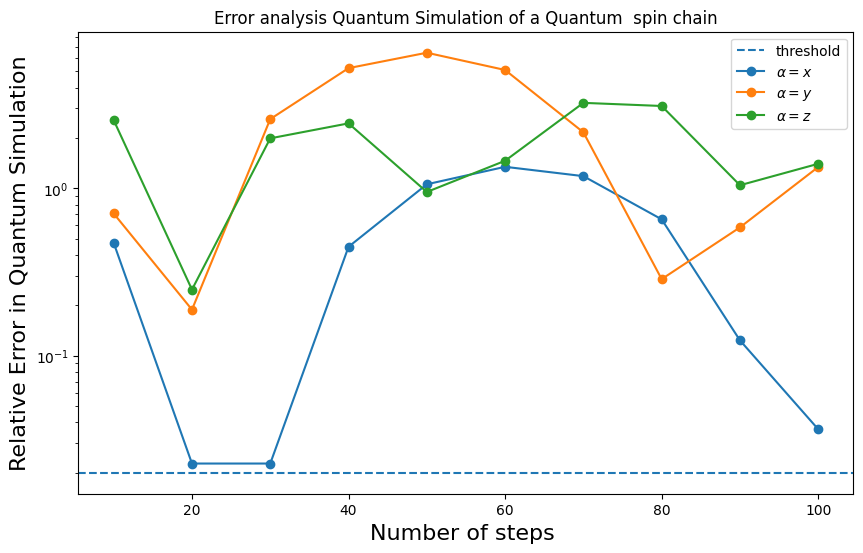

In [56]:
fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(0.02,ls='--',label='threshold')
ax.plot(m_list,np.abs((np.array(mx_list2) -(sx_expt[20]))/sx_expt[20]),'-o',c='C0',label=r'$\alpha=x$')
ax.plot(m_list,np.abs((np.array(my_list2) -(sy_expt[20]))/sy_expt[20]),'-o',c='C1',label=r'$\alpha=y$')
ax.plot(m_list,np.abs((np.array(mz_list2) -(sz_expt[20]))/sz_expt[20]),'-o',c='C2',label=r'$\alpha=z$')
ax.set_yscale('log')
ax.legend(loc=0)
ax.set_xlabel(r'Number of steps ',fontsize=16)
ax.set_ylabel(r'Relative Error in Quantum Simulation',fontsize=16)
ax.set_title(r'Error analysis Quantum Simulation of a Quantum  spin chain');

The total number of gates for below threshold measurment:

In [57]:
m=90 # Fill this  # put in the smallest m to meet the criteria
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ)
circ=first_order_PF(circ,t,m,J,Bx,By,Bz)
circ_measured=measurement_circuits(circ)
print(circ_measured[0].count_ops())
print(circ_measured[1].count_ops())
print(circ_measured[2].count_ops())

OrderedDict([('rz', 1170), ('ry', 900), ('cx', 810), ('rx', 360), ('barrier', 180), ('x', 4), ('h', 4), ('measure', 4)])
OrderedDict([('rz', 1170), ('ry', 900), ('cx', 810), ('rx', 360), ('barrier', 180), ('x', 4), ('sdg', 4), ('h', 4), ('measure', 4)])
OrderedDict([('rz', 1170), ('ry', 900), ('cx', 810), ('rx', 360), ('barrier', 180), ('x', 4), ('measure', 4)])
